In [1]:
from __future__ import division

import os
import numpy as np
import time, timeit
import signal
import scipy.io as scio
from scipy import stats
from scipy.sparse import coo_matrix
from MDPD import *
from MDPD.readers import *
from MDPD import utils
import matplotlib.pyplot as plt
import matplotlib

----
## Read Data

In [ ]:
folder = '/media/vzhao/Data/crowdsourcing_datasets/bird'
train = Crowd_Sourcing_Readers.read_data(os.path.join(folder, 'bluebird_crowd.txt'))
label = Crowd_Sourcing_Readers.read_label(os.path.join(folder, 'bluebird_truth.txt'))
lock = np.zeros(train.shape[1:])

In [ ]:
folder = '/media/vzhao/Data/crowdsourcing_datasets/dog'
train = Crowd_Sourcing_Readers.read_data(os.path.join(folder, 'dog_crowd.txt'))
label = Crowd_Sourcing_Readers.read_label(os.path.join(folder, 'dog_truth.txt'))


In [ ]:
folder = '/media/vzhao/Data/crowdsourcing_datasets/rte'
train = Crowd_Sourcing_Readers.read_data(os.path.join(folder, 'rte_crowd.txt'))
label = Crowd_Sourcing_Readers.read_label(os.path.join(folder, 'rte_truth.txt'))
lock = np.zeros(train.shape[1:])
lock[:, -1] = 1

In [ ]:
folder = '/media/vzhao/Data/crowdsourcing_datasets/trec'
train = Crowd_Sourcing_Readers.read_data(os.path.join(folder, 'trec_crowd.txt'))
label = Crowd_Sourcing_Readers.read_label(os.path.join(folder, 'trec_truth.txt'))

In [2]:
folder = '/media/vzhao/Data/crowdsourcing_datasets/web'
train = Crowd_Sourcing_Readers.read_data(os.path.join(folder, 'web_crowd.txt'))
label = Crowd_Sourcing_Readers.read_label(os.path.join(folder, 'web_truth.txt'))
lock = np.zeros(train.shape[1:])
lock[:, -1] = 1

2018-03-30 14:24:51,500 : INFO : Data has missing values. A new label is created to represent the missing values.
2018-03-30 14:24:51,521 : INFO : The Data has 177 dimensions, 2665 samples, and 6 volcabulary size.


---
## Analysis

### Original Mutual Information Residue

In [3]:
# Original mutual information residue (G score)
score = MDPD.utils.Feature_Selection.MI_score(train, rm_diag=True, lock=lock)
dim = train.shape[1]
print np.sum(score) / (dim * (dim-1))

0.000758252607433816


MDPD/utils.py:183: RuntimeWarning: divide by zero encountered in log
  pmi = second * (np.log(second) - logfirst)
MDPD/utils.py:183: RuntimeWarning: invalid value encountered in multiply
  pmi = second * (np.log(second) - logfirst)


### Reference G Statistics

In [4]:
percentages = [99,95,90,75,50]
percentiles = [stats.chi2.ppf(x/100.,3) / (2 * train.shape[0]) for x in percentages]

print 'Reference G statistis at {} percentile'.format(percentages)
print percentiles

Reference G statistis at [99, 95, 90, 75, 50] percentile
[0.002128492819914516, 0.0014661778430114778, 0.001172868411101374, 0.0007707964231955565, 0.0004438975392824273]


### Mixture Model with Feature Selection Performance

#### Feature Ranking

array([  2,   0,  11,   6,  15,  12,   7,   1,   3,  10,  53,  54,   8,
        29,  62,  13,  25,  28,  64,  32,  52,  56,  78,  55,  36,  23,
        21,  61,  77,  40,  84,  44,  35,  75,  51,  65,  33,  43,  20,
        67,  58,  38, 100,  46,  92,  16,  83,  24,  41, 103,  39, 105,
        74,  31,  86,  90, 117,  70,  69,  63, 109,  50,  27, 102,  17,
        93,   5,  30, 114,  81,  71,  87,  68,  22,  19, 132,  72, 106,
        57, 104,  26, 107,  37,  60, 134,  82,  48, 129, 124,  76,  18,
        47,  34,  14, 142,  98,   9, 126, 108,  99, 130, 101, 145, 155,
       118,  91, 113,  85, 120,  49,   4, 141,  89,  96, 119,  73, 140,
       143,  59, 144, 139, 158, 127, 147, 112,  42, 135,  88,  94, 122,
        80, 125, 138, 121, 161,  95,  45, 123, 164,  66, 128, 116, 111,
       153,  79, 110, 165, 157, 151, 133,  97, 146, 156, 174, 168, 160,
       115, 131, 159, 173, 150, 162, 137, 148, 167, 166, 169, 171, 176,
       163, 172, 136, 170, 175, 149, 154, 152])

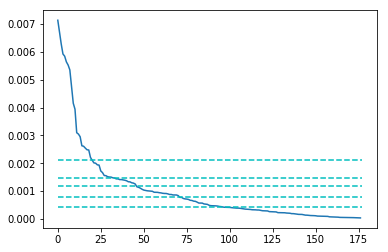

In [5]:
features, score = utils.Feature_Selection.MI_feature_ranking(train)
plt.plot(score/(train.shape[1]-1))
# plot reference G statistics
for foo in percentiles:
    plt.plot([0, len(score)], [foo, foo], 'c--')
features

#### Accuracy and Mutual Information Residue

In [6]:
# Feature Selection
Ntop = 9
model = MDPD.MDPD()
model.fit(train, ncomp=5, init='majority', verbose=False, features=features[:Ntop], niter=50, lock=lock)
model.accuracy(train, label)
model.MI_residue(train, lock)

2018-03-30 14:26:10,335 : INFO : Training an MDPD with dimension 9, sample size 2665, vocab size 6 and the target number of components 5
MDPD/utils.py:100: RuntimeWarning: divide by zero encountered in log
  log_votes = np.log(votes)
2018-03-30 14:26:11,729 : INFO : ACCURACY: 88.74%
MDPD/utils.py:253: RuntimeWarning: divide by zero encountered in log
  pmi = second * (np.log(second) - log_first)
MDPD/utils.py:253: RuntimeWarning: invalid value encountered in multiply
  pmi = second * (np.log(second) - log_first)
2018-03-30 14:26:13,517 : INFO : The mutual information residue is 0.000733226590835
2018-03-30 14:26:13,518 : INFO : The mutual information residue of the feature set is -0.00983629074804


In [ ]:
# optional
model.change_features(train, features=range(model.dim))
model.accuracy(train, label)

### Vanilla Model Performance
#### Accuracy

In [7]:
# basic model with majority vote initialization
model_basic = MDPD.MDPD()
model_basic.fit(train, ncomp=4, init='majority', verbose=False, niter=50, lock=lock)
model_basic.accuracy(train, label)

2018-03-30 14:29:52,170 : INFO : Training an MDPD with dimension 177, sample size 2665, vocab size 6 and the target number of components 4
MDPD/MDPD.py:234: RuntimeWarning: divide by zero encountered in log
  log_margin_prob = np.log(data_selected.sum(axis=0) / data_selected.shape[0])
2018-03-30 14:30:21,893 : INFO : ACCURACY: 82.66%


0.8266416510318949

#### Mutual Information Residue

In [8]:
model_basic.MI_residue(train, lock)
# MI residue conditional on the features (although basic model is using all features to learn the model)
features, score = utils.Feature_Selection.MI_feature_ranking(train)
features = np.array(features)
log_post = model_basic.log_posterior(train)
score, weights = utils.Feature_Selection.MI_score_conditional(train,log_post,rm_diag=True, lock=lock)
score_selected = score[features[:Ntop, np.newaxis], features[:Ntop]]
print 'MI residue conditional on the features (although basic model is using all features to learn the model)'
print np.sum(score_selected.sum(axis=(0,1)) * weights) / (Ntop * (Ntop - 1))

2018-03-30 16:14:55,787 : INFO : The mutual information residue is 0.00073482327462
2018-03-30 16:14:55,789 : INFO : The mutual information residue of the feature set is 0.00073482327462


MI residue conditional on the features (although basic model is using all features to learn the model)
-0.006733611156566834
